# Análisis del Dataset

Visualización y clustering (Aprendizaje No Supervisado)

### Se levanta dataset del archivo .csv previamente generado

In [56]:
import pandas as pd

data = pd.read_csv('snd-dataset-from-plain-json.csv')
data.head()

,Duration,Loudness,LogAttackTime,Tempo,Tempo.confidence,TemporalCentroid,SingleEvent,Loop,Tonality,Tonality.confidence,DynamicRange,Note.midi,Note.frequency,Note.confidence,Genre,Mood
0,24.218412,-16.581459,0.769376,95,0.133154,0.498596,False,False,G major,0.524679,9.689243,55,197.972900,0.000000,Genre B,Mood B
1,243.983673,-16.891335,1.618665,65,0.545527,0.479576,False,False,G major,0.785114,5.247044,40,85.456451,0.000000,Genre A,Mood A
2,15.281632,-21.658251,0.582658,63,0.996905,0.492315,True,True,C minor,0.698095,1.060242,50,151.972198,0.352345,Genre B,Mood B
3,2.000000,-10.525232,-1.590209,119,0.000000,0.468918,False,False,G# minor,0.646680,0.000000,41,91.402817,0.000000,Genre A,Mood A
4,1.454150,-28.335722,-0.492548,152,0.000000,0.502481,True,False,F# minor,0.408481,0.000000,107,3984.657227,0.695633,Genre A,Mood A


In [57]:
print("Cantidad de instancias: %i"%data.shape[0])

Cantidad de instancias: 1017


In [58]:
# se filtran los sonidos de menos de 5 segundos
samples = data[ data['Duration'] < 5 ]
print("Cantidad de instancias menores a 5 segundos: %i"%samples.shape[0])

Cantidad de instancias menores a 5 segundos: 70


**Como se dijo, originalmente la idea era analizar aquellos sonidos cuya duración era menor a 5 segundos, ya que a priori se pensaba que de los mismos se podía extraer mejor información, ya que su contenido no varia tanto en el tiempo, pero se descartó, ya que se encontró que el dataset elegido contaba con muy pocas instancias de este tipo. Sobre 1017, solo 70 cumplen con esta condición, menos de un 7%.**

# Descripción de los features

**duration**: Duration of audio file in seconds.

**loudness**: The integrated (overall) loudness (LUFS) measured using the EBU R128 standard.

**log_attack_time**: The log (base 10) of the attack time of a signal envelope. The attack time is defined as the time duration from when the sound becomes perceptually audible to when it reaches its maximum intensity.

**tempo**: BPM value estimated by beat tracking algorithm.

**tempo_confidence**: Reliability of the tempo estimation above (in a range between 0 and 1).

**temporal_centroid**: Temporal centroid (sec.) of the audio signal. It is the point in time in a signal that is a temporal balancing point of the sound event energy.

**single_event**: Whether the audio file contains one single audio event or more than one (true or false). This computation is based on the loudness of the signal and does not do any frequency analysis.

**loop**: Whether audio file is loopable (true or false).

**tonality**: Key value estimated by key detection algorithm.

**tonality_confidence**: Reliability of the key estimation above (in a range between 0 and 1).

**dynamic_range**: Loudness range (dB, LU) measured using the EBU R128 standard.

**note_midi**: MIDI value corresponding to the estimated note.

**note_frequency**: Frequency corresponding to the estimated note.

**note_confidence**: Reliability of the note name/midi/frequency estimation above (in a range between 0 and 1).

**genre**: Music genre of the analysed music track (not yet implemented).

**mood**: Mood estimation for the analysed music track (not yet implemented).

**Referencia**: https://github.com/AudioCommons/ac-audio-extractor


## Se filtra y solo se dejan las columnas de interés para agrupar

Básicamente se descartan los valores de 'confidence' (confianza)

In [1]:
# Descarto columnas que no se van a usar por ahora
# Tip: axis number (0 for rows and 1 for columns)
data = data.drop("Tempo.confidence", axis=1);
data = data.drop("Tonality.confidence", axis=1);
data = data.drop("Note.confidence", axis=1);

# Según la documentación (Referencia: https://github.com/AudioCommons/ac-audio-extractor) Genre y Mood
# todavía no están correctamente implementadas, así que se descarta su valor
data = data.drop("Genre", axis=1);
data = data.drop("Mood", axis=1);
data.head()

NameError: name 'data' is not defined

## Visualización del dataset

In [60]:
from sklearn import datasets
from sklearn.cluster import KMeans

import sklearn.metrics as sm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [61]:
AMOUNT = data.shape[0]

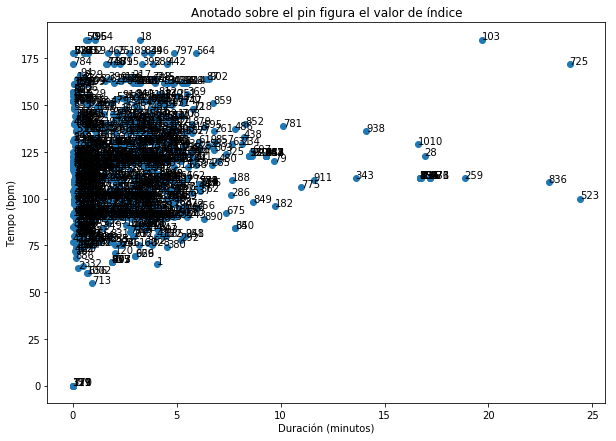

In [62]:
# Plot de duración vs tempo, anotando el número de track en cada punto/marker...
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(data.Duration/60.,data.Tempo, ls="", marker="o")
for xi, yi, pidi in zip(data.Duration/60.,data.Tempo,data.index):
    ax.annotate(str(pidi), xy=(xi,yi))

plt.title('Anotado sobre el pin figura el valor de índice')
plt.xlabel('Duración (minutos)')
plt.ylabel('Tempo (bpm)')
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


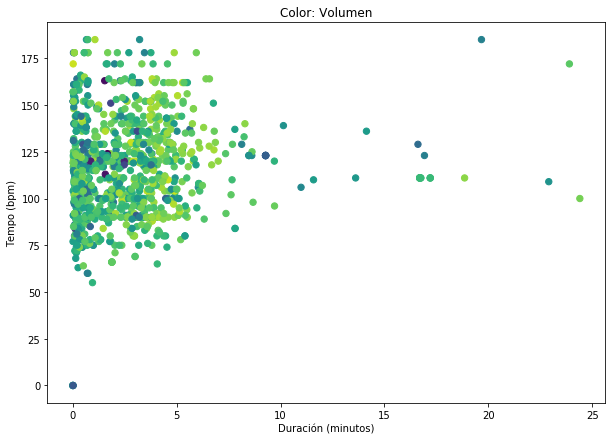

In [63]:
colormap_original = cm.viridis_r(np.linspace(0,1,abs(np.max(abs(data.Loudness)*AMOUNT))+1))

plt.figure(figsize=(10,7))
plt.scatter(data.Duration/60., data.Tempo, c=colormap_original[(abs(data.Loudness)*AMOUNT).astype(int) ], s=40)
plt.title('Color: Volumen') # más oscuro es más alto

plt.xlabel('Duración (minutos)')
plt.ylabel('Tempo (bpm)')
plt.show()

**Observación: Predominan los sonidos con duración entre 0 y 5 minutos, con tempo entre 75 y 175 BPM (beats per minute). Y con un volumen (loudness) bastante parejo.**

## Agrupación por k-means

Se utiliza k-means, un algoritmo de clustering (no supervisado)

In [64]:
# Pasar categorias columna 'Tonality' a numérica

key_to_number_list = ['A minor', 'A major', 'A# minor', 'A# major', 'B minor', 'B major', 'C minor', 'C major', 'C# minor', 'C# major', 'D minor', 'D major', 'D# minor', 'D# major','E minor', 'E major', 'F minor', 'F major', 'F# minor', 'F# major', 'G minor', 'G major','G# minor', 'G# major']

def keyToNumber(x_value):
    return [i for i,x in enumerate(key_to_number_list) if x == x_value][0]

# Mapeo de las tonalidades 'en texto' a categorias numéricas
data['Tonality'] = data['Tonality'].map(keyToNumber)

In [65]:
data['Genre'] = data['Genre'].map(lambda x: 1 if x=='Genre A' else 0)
data['Mood'] = data['Mood'].map(lambda x: 1 if x=='Mood A' else 0)

In [66]:
# dataset adaptado
data.head()

,Duration,Loudness,LogAttackTime,Tempo,TemporalCentroid,SingleEvent,Loop,Tonality,DynamicRange,Note.midi,Note.frequency,Genre,Mood
0,24.218412,-16.581459,0.769376,95,0.498596,False,False,21,9.689243,55,197.972900,0,0
1,243.983673,-16.891335,1.618665,65,0.479576,False,False,21,5.247044,40,85.456451,1,1
2,15.281632,-21.658251,0.582658,63,0.492315,True,True,6,1.060242,50,151.972198,0,0
3,2.000000,-10.525232,-1.590209,119,0.468918,False,False,22,0.000000,41,91.402817,1,1
4,1.454150,-28.335722,-0.492548,152,0.502481,True,False,18,0.000000,107,3984.657227,1,1


In [67]:
# se configura la cantidad de clusters pre-definida
#num_clusters = 3
num_clusters = 8

model = KMeans(n_clusters=num_clusters) 
model.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

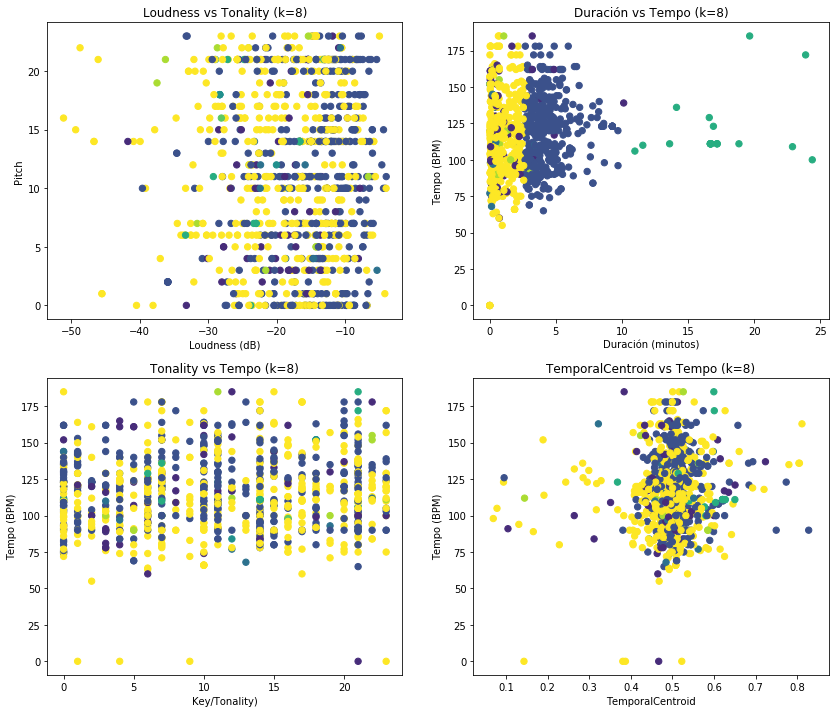

In [71]:
# Comparaciones para comprender el dataset

plt.figure(figsize=(14,12))

colormap_original = cm.viridis_r(np.linspace(0,1,num_clusters+1))

# Loudness vs Pitch
plt.subplot(2, 2, 1)
plt.scatter(data.Loudness, data.Tonality, c=colormap_original[model.labels_], s=40)
plt.title('Loudness vs Tonality (k=%s)'%num_clusters)
plt.xlabel('Loudness (dB)')
plt.ylabel('Pitch')

# Duración vs Tempo
plt.subplot(2, 2, 2)
plt.scatter(data.Duration/60., data.Tempo, c=colormap_original[model.labels_], s=40)
plt.title('Duración vs Tempo (k=%s)'%num_clusters)
plt.xlabel('Duración (minutos)')
plt.ylabel('Tempo (BPM)')

# Key vs Tempo
plt.subplot(2, 2, 3)
plt.scatter(data.Tonality, data.Tempo, c=colormap_original[model.labels_], s=40)
plt.title('Tonality vs Tempo (k=%s)'%num_clusters)
plt.xlabel('Key/Tonality)')
plt.ylabel('Tempo (BPM)')

# TemporalCentroid
plt.subplot(2, 2, 4)
plt.scatter(data.TemporalCentroid, data.Tempo, c=colormap_original[model.labels_], s=40)
plt.title('TemporalCentroid vs Tempo (k=%s)'%num_clusters)
plt.xlabel('TemporalCentroid')
plt.ylabel('Tempo (BPM)')

plt.show()

**Observación: En 'Duración vs Tempo' se observan 3 grupos bien definidos de sonidos que comparten características, entre 0 y 3 minutos aproximadamente, 3 y 10, y más de 10 minutos. El tempo se ubica promedio alrededor de los 125 BPM y se distribuye hacia arriba y abajo de manera practicamente uniforme. La ubicación deel centroide temporal esta concentrada en el centro (ver diagrama vs el Tempo).**

Text(0, 0.5, 'Duración (minutos)')

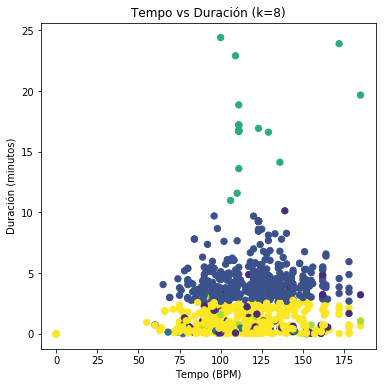

In [70]:
# Tempo vs Duración

plt.figure(figsize=(6,6))
plt.scatter(data.Tempo, data.Duration/60., c=colormap_original[model.labels_], s=40)
plt.title('Tempo vs Duración (k=%s)'%num_clusters)

plt.xlabel('Tempo (BPM)')
plt.ylabel('Duración (minutos)')

In [21]:
max(model.labels_)

7

## Posibles outliers

Por inspección ocular se observan algunos posibles *'outliers'*.

![](img/posibles-outliers.png)

![posibles outliers](img/posibles_outliers.png)

# Conclusión parcial

Se obtuvo una idea general de la composición del dataset que puede ser de utilidad para aplicar otros algoritmos.

---

**Siguiente:** [2a - Regresión Logística y análisis del dataset con R](2a%20-%20Regresión%20Logística%20y%20análisis%20del%20dataset%20con%20R.ipynb)
